# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.8.0


# Загружаем разметку

In [57]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['dol'][0]['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
boxes = load_annotations()  # загружаем разметку детекций

In [4]:
boxes

{'dol': [{'annotations': [{'class': 'rect',
     'height': 69.09000000000015,
     'width': 227.0100000000005,
     'x': 511.12500000000114,
     'y': 460.365000000001}],
   'class': 'image',
   'filename': 'data/fish/train/DOL/img_03922.jpg'},
  {'annotations': [{'class': 'rect',
     'height': 174.84000000000037,
     'width': 71.91000000000008,
     'x': 756.4650000000016,
     'y': 363.78000000000077}],
   'class': 'image',
   'filename': 'data/fish/train/DOL/img_01812.jpg'}],
 'bet': [{'annotations': [{'class': 'rect',
     'height': 144.0,
     'width': 371.0,
     'x': 897.5,
     'y': 468.0}],
   'class': 'image',
   'filename': 'data/fish/train/BET/img_06862.jpg'},
  {'annotations': [{'class': 'rect',
     'height': 239.0,
     'width': 514.0,
     'x': 758.0,
     'y': 144.5}],
   'class': 'image',
   'filename': 'data/fish/train/BET/img_05262.jpg'},
  {'annotations': [{'class': 'rect',
     'height': 191.0,
     'width': 332.0,
     'x': 452.0,
     'y': 258.5},
    {'class'

In [5]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,dol,2
1,bet,5
2,shark,4
3,yft,12
4,lag,2
5,alb,27


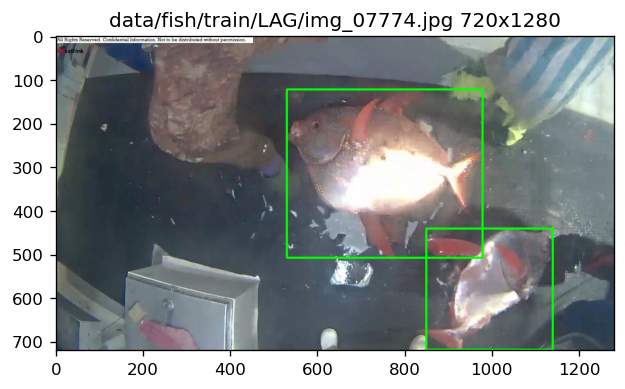

In [6]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

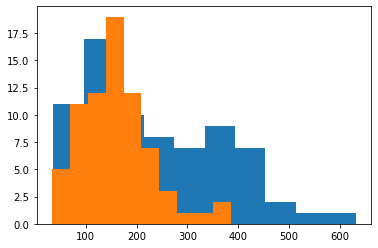

In [7]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [8]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [9]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [110]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(boxes, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 10), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    step = 6
    for fish in boxes:
        for annotation in boxes[fish]:
            for rect in annotation['annotations']:
                scores = []
                for row in range(FEATURE_SHAPE[0]):
                    for col in range(FEATURE_SHAPE[1]):
                        anchor_x = ANCHOR_CENTERS[1, row, col]
                        anchor_y = ANCHOR_CENTERS[0, row, col]
                        score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                        item_score = [0, 0, 0, 0, 0, 0, anchor_x, anchor_y, row, col]
                        item_score[6-step] = score                        
                        scores.append(tuple(item_score))

                scores = sorted(scores, reverse=True)
                
                if scores[0][6-step] < iou_thr:
                    scores = [scores[0]]  # default anchor
                else:
                    scores = [e for e in scores if e[0] > iou_thr]

                for score_dol, score_bet, score_shark, score_yft, score_lag, score_alb, anchor_x, anchor_y, row, col in scores:
                    dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
                    dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
                    dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
                    dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
                    # Добавил разметку onehotencoding для классов рыб
                    encoded[row, col] = [score_dol, score_bet, score_shark, score_yft, score_lag, score_alb, dx, dy, dw, dh]
        
        step -= 1
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    logit = 0
#     print(prediction)
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            dol, bet, shark, yft, lag, alb, dx, dy, dw, dh = prediction[row, col]
            if dol != 0 or bet != 0 or shark != 0 or yft != 0 or lag != 0 or alb != 0:
                if dol != 0:
                    logit = dol
                elif bet != 0:
                    logit = bet
                elif shark != 0:
                    logit = shark
                elif yft != 0:
                    logit = yft
                elif lag != 0:
                    logit = lag
                elif alb != 0:
                    logit = alb

                conf = _sigmoid(logit)
                if conf > conf_thr:
                    anchor_x = ANCHOR_CENTERS[1, row, col]
                    anchor_y = ANCHOR_CENTERS[0, row, col]
                    rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                       'y': anchor_y - dy * ANCHOR_HEIGHT,
                                       'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                       'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                       'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

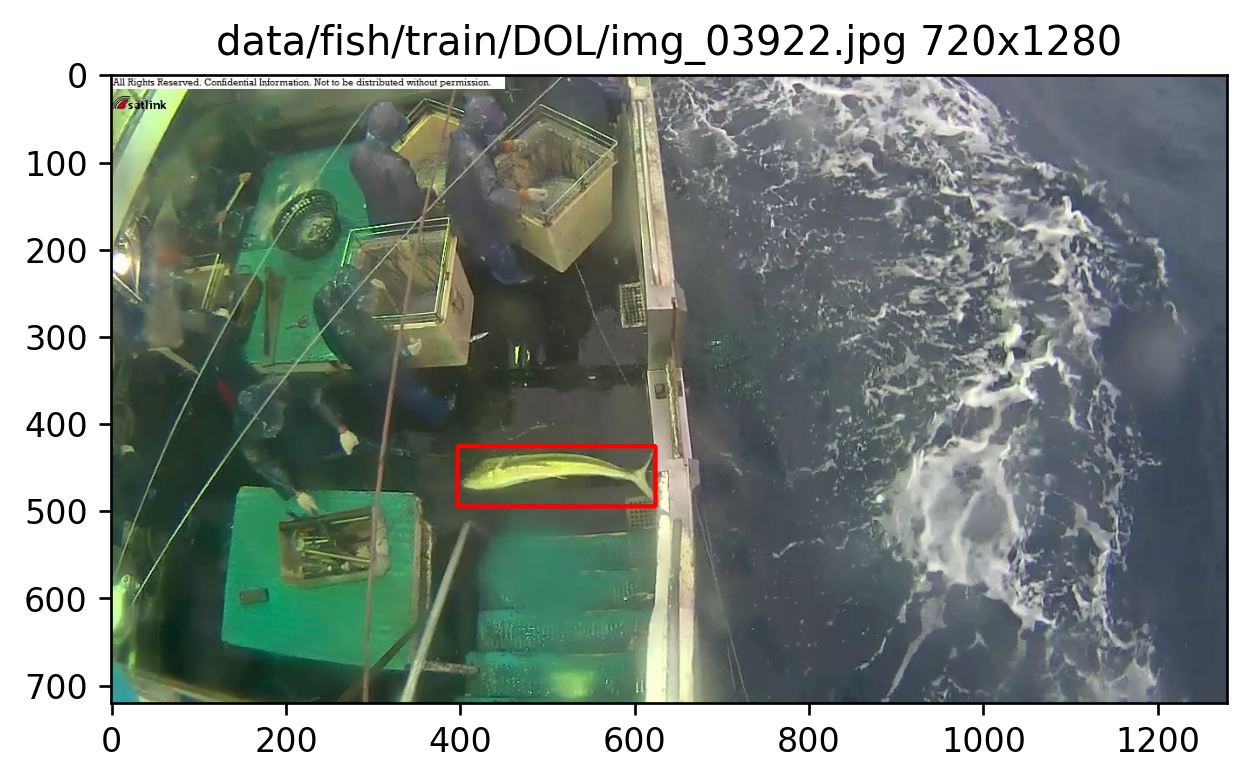

In [112]:
annotation = {'dol':[boxes['dol'][0]]}

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=240)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['dol'][0]['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [113]:
K = tf.keras.backend.categorical_crossentropy

# Заменил бинарную кроссэнтропию на категориальную (т.к. имеем дело с многоклассовой классификацией)
def confidence_loss(y_true, y_pred):
    conf_loss = K.categorical_crossentropy(y_true[0, 1, 2, 3, 4, 5], 
                                      y_pred[0, 1, 2, 3, 4, 5],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [114]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    count_boxes = sum(boxes.values(), [])
    while True:
#         shuffle(boxes)
        for i in range(len(count_boxes)//batch_size):
            X, y = [], []
#             for j in range(i*batch_size,(i+1)*batch_size):
#                 print('Iteration third')
            for fish in boxes:
                for annot in boxes[fish]:
                    img_shape, img = load_img(annot['filename'])
                    # Применяем кодировку анкоров функцией, которая выдает one-hot encoding классов рыб
                    y.append(encode_anchors(boxes, img_shape))
                    X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [115]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# Заменил один выход с определением есть рыба или на 6 соответствующие 6 классам рыб
output = tf.keras.layers.Conv2D(10,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

## Обучение

In [116]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

In [117]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

# Но нейросеть не взлетела... Нужна, что сделал не так, и как сделать правильно

Epoch 1/100


AttributeError: in user code:

    File "/Users/vandal/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-66-d4fe372adbaf>", line 18, in total_loss  *
        batch_size = K.shape(y_true)[0]

    AttributeError: 'function' object has no attribute 'shape'


## Результат работы детектора

In [ ]:
model.load_weights('data/fish/fishdetector_weights.hdf5')

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

In [ ]:
test_images = glob('data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0